# Regression Target Adjustments 

**Status**: Historical analysis notebook documenting target variable decisions.

**Key Findings** (preserved from original analysis on full dataset):
1. Time-based discounting: Low correlation (0.1-0.2) between days since review and UFC votes - **No adjustment needed**
2. Business popularity discounting: No correlation between business review count and UFC votes - **No adjustment needed**

These findings informed the target variable design in Stage 1 ETL.

The original regression target is the sum of the useful, funny, and cool (UFC) votes that a review receives.

Possible Adjustments to the original target:
1. Discounting based on time since the review.
    * Hypothesis: The longer a review has been around, the more time it has to accumulate votes.
    * Decision: No Adjustments - Low correlation between days since review and review ufc count (0.1 with all data and 0.2 with outliers removed.
    * Adjustment: None
2. Discounting based on the review count of the business.
    * Hypothesis: The more reviews a business receives, the more popular the business, the more people reading the businesses reviews, the more upvotes for those reviews.
    * Decision: No Adjustments - No correlation between business review count and review ufc count.
    * Adjustment: None

### Imports and Global Settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
sns.set_theme(style="whitegrid")

### Import Data

In [2]:
filepath = "/home/ubuntu/"
reviews_filename = "yelp_reviews.csv"
business_filename = "yelp_business.csv"
train_filename = "train.csv"
test_filename = "test.csv"

In [3]:
reviews = pd.read_csv(filepath+reviews_filename,
                      parse_dates=['date'], infer_datetime_format=True,
                      usecols=['review_id', 'business_id', 'date'])
businesses = pd.read_csv(filepath+business_filename)
train = pd.read_csv(filepath+train_filename,
                    true_values=["True"], false_values=["False"],
                    usecols=['review_id', 'target_clf', 'target_reg'])
test = pd.read_csv(filepath+test_filename,
                   true_values=["True"], false_values=["False"],
                   usecols=['review_id', 'target_clf', 'target_reg'])

## Data Prep and Overview

In [4]:
for df in [reviews, businesses, train, test]:
    print(df.shape)

(8635403, 3)
(160585, 2)
(5523992, 3)
(1382379, 3)


In [5]:
train_df = pd.merge(train, reviews, how="left", on="review_id", validate="1:m").merge(businesses, how="left", on="business_id")

In [6]:
test_df = pd.merge(test, reviews, how="left", on="review_id", validate="1:m").merge(businesses, how="left", on="business_id")

In [7]:
STOP_DATE = pd.to_datetime('2021-02-01 00:00:00')
STOP_DATE

Timestamp('2021-02-01 00:00:00')

In [8]:
train_df["time_since_review"] = STOP_DATE - train_df["date"]
train_df["days_since_review"] = train_df["time_since_review"].dt.days

test_df["time_since_review"] = STOP_DATE - test_df["date"]
test_df["days_since_review"] = test_df["time_since_review"].dt.days

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5523992 entries, 0 to 5523991
Data columns (total 8 columns):
 #   Column             Dtype          
---  ------             -----          
 0   review_id          object         
 1   target_clf         bool           
 2   target_reg         int64          
 3   business_id        object         
 4   date               datetime64[ns] 
 5   review_count       int64          
 6   time_since_review  timedelta64[ns]
 7   days_since_review  int64          
dtypes: bool(1), datetime64[ns](1), int64(3), object(2), timedelta64[ns](1)
memory usage: 342.4+ MB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1382379 entries, 0 to 1382378
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype          
---  ------             --------------    -----          
 0   review_id          1382379 non-null  object         
 1   target_clf         1382379 non-null  bool           
 2   target_reg         1382379 non-null  int64          
 3   business_id        1382379 non-null  object         
 4   date               1382379 non-null  datetime64[ns] 
 5   review_count       1382379 non-null  int64          
 6   time_since_review  1382379 non-null  timedelta64[ns]
 7   days_since_review  1382379 non-null  int64          
dtypes: bool(1), datetime64[ns](1), int64(3), object(2), timedelta64[ns](1)
memory usage: 85.7+ MB


In [11]:
train_df_short = train_df[['target_reg', 'review_count', 'days_since_review']]
train_df_short.shape

(5523992, 3)

In [12]:
train_df_no_outliers = train_df_short[(np.abs(stats.zscore(train_df_short)) < 3).all(axis=1)]
train_df_no_outliers.shape

(5355560, 3)

## All Data

In [13]:
corr = train_df_short.corr()
corr.style.background_gradient(cmap='coolwarm')

,target_reg,review_count,days_since_review
target_reg,1.000000,-0.021283,0.097878
review_count,-0.021283,1.000000,0.023027
days_since_review,0.097878,0.023027,1.000000


### UFC Count Distribution

<AxesSubplot:title={'center':'Review UFC Count'}, xlabel='target_reg', ylabel='Count'>

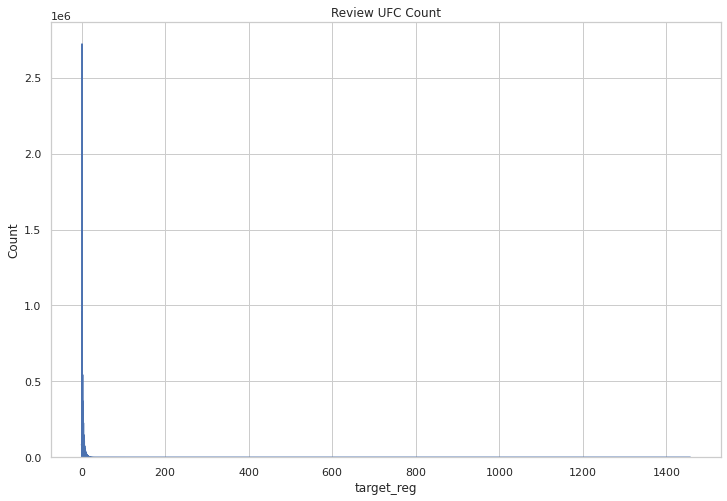

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Review UFC Count")
sns.histplot(train_df_short, x="target_reg", ax=ax, kde=True, element="step")

### Days Since Review Distribution

<AxesSubplot:title={'center':'Days Since Review'}, xlabel='days_since_review', ylabel='Count'>

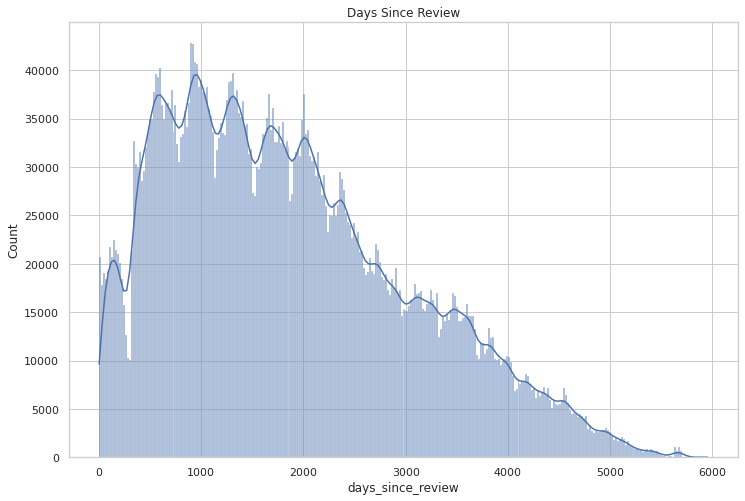

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Days Since Review")
sns.histplot(train_df_short, x="days_since_review", ax=ax, kde=True)

<AxesSubplot:title={'center':'Days Since Review VS Review UFC Count'}, xlabel='days_since_review', ylabel='target_reg'>

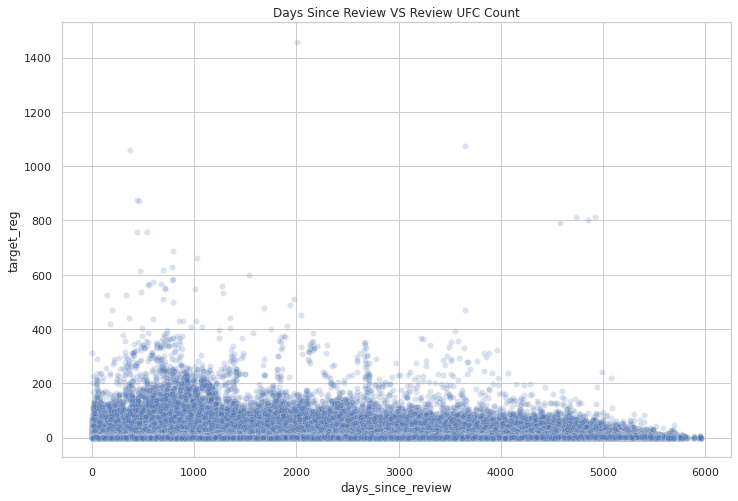

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Days Since Review VS Review UFC Count")
sns.scatterplot(data=train_df_short, x="days_since_review", y="target_reg", ax=ax, alpha=0.2)

### Business Review Count

<AxesSubplot:title={'center':'Business Review Count'}, xlabel='review_count', ylabel='Count'>

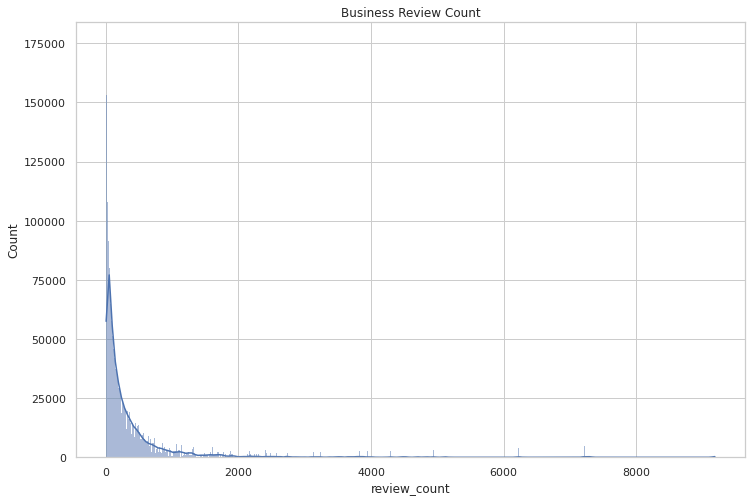

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Business Review Count")
sns.histplot(train_df_short, x="review_count", ax=ax, kde=True)

<AxesSubplot:title={'center':'Business Review Count VS Review UFC Count'}, xlabel='review_count', ylabel='target_reg'>

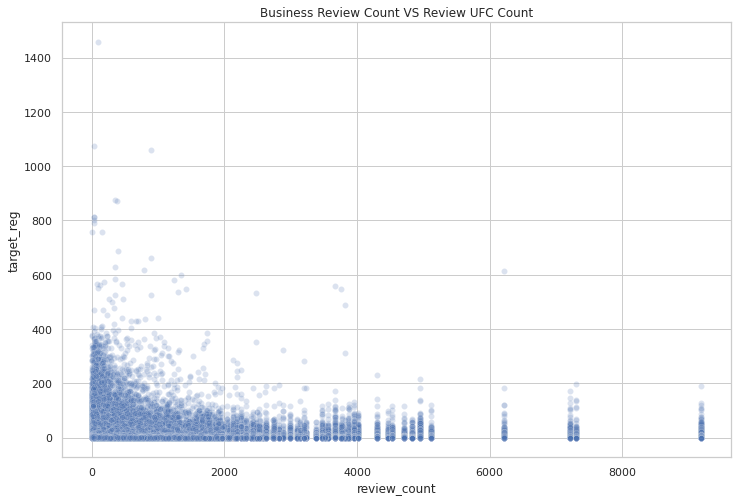

In [18]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Business Review Count VS Review UFC Count")
sns.scatterplot(data=train_df_short, x="review_count", y="target_reg", ax=ax, alpha=0.2)

## Outliers Removed

In [19]:
corr = train_df_no_outliers.corr()
corr.style.background_gradient(cmap='coolwarm')

,target_reg,review_count,days_since_review
target_reg,1.000000,-0.053748,0.203847
review_count,-0.053748,1.000000,0.033326
days_since_review,0.203847,0.033326,1.000000


### UFC Count Distribution

<AxesSubplot:title={'center':'Review UFC Count'}, xlabel='target_reg', ylabel='Count'>

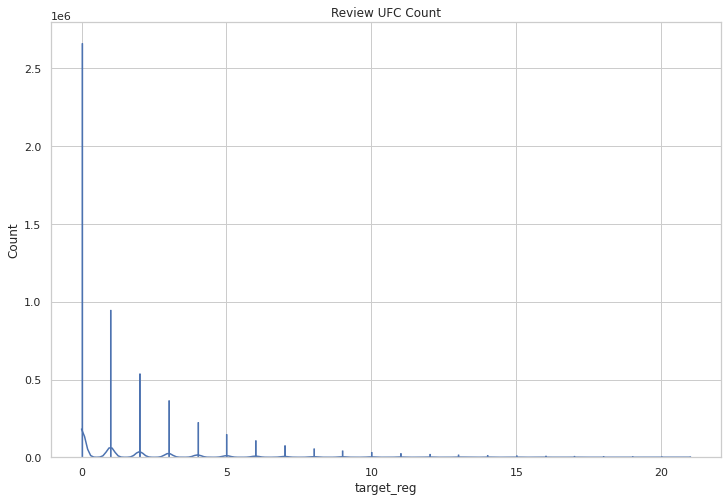

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Review UFC Count")
sns.histplot(train_df_no_outliers, x="target_reg", ax=ax, kde=True, element="step")

### Days Since Review Distribution

<AxesSubplot:title={'center':'Days Since Review'}, xlabel='days_since_review', ylabel='Count'>

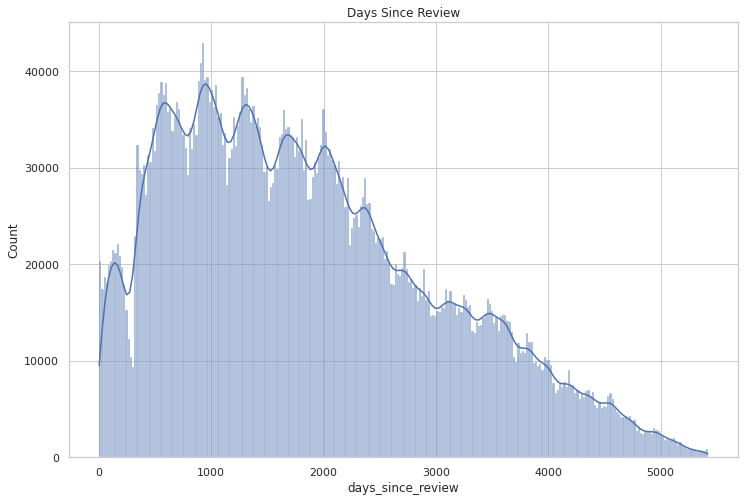

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Days Since Review")
sns.histplot(train_df_no_outliers, x="days_since_review", ax=ax, kde=True)

<AxesSubplot:title={'center':'Days Since Review VS Review UFC Count'}, xlabel='days_since_review', ylabel='target_reg'>

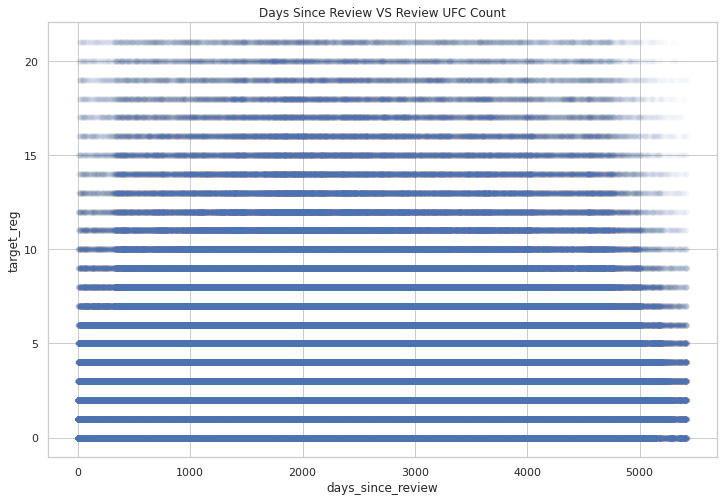

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Days Since Review VS Review UFC Count")
sns.scatterplot(data=train_df_no_outliers, x="days_since_review", y="target_reg", ax=ax, alpha=0.01)

### Business Review Count

<AxesSubplot:title={'center':'Business Review Count'}, xlabel='review_count', ylabel='Count'>

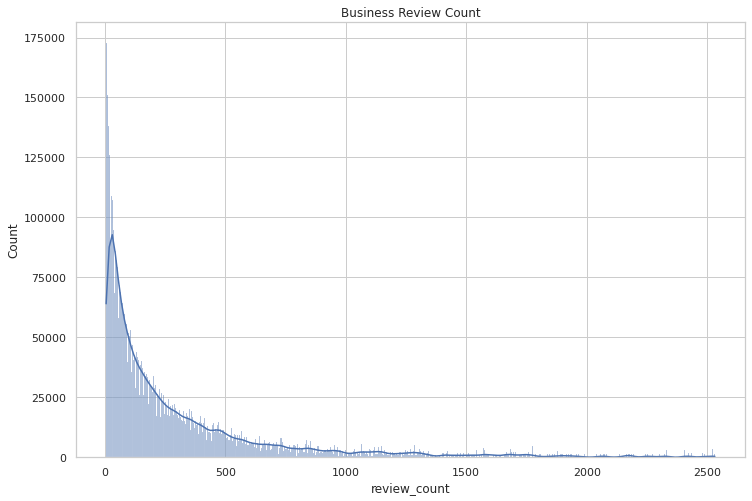

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Business Review Count")
sns.histplot(train_df_no_outliers, x="review_count", ax=ax, kde=True)

<AxesSubplot:title={'center':'Business Review Count VS Review UFC Count'}, xlabel='review_count', ylabel='target_reg'>

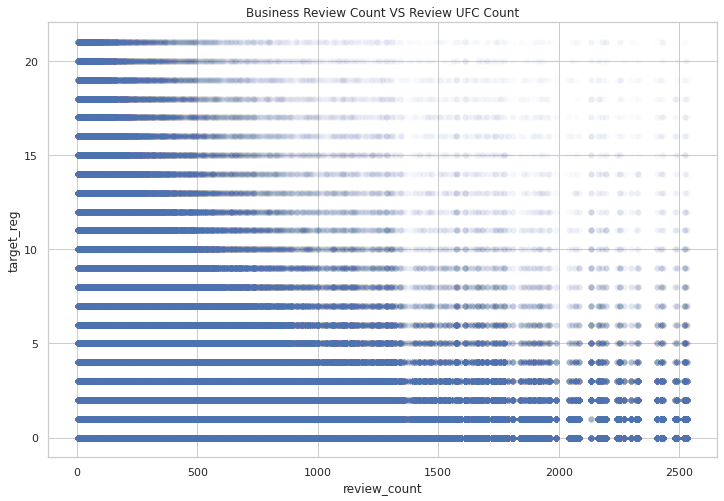

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title("Business Review Count VS Review UFC Count")
sns.scatterplot(data=train_df_no_outliers, x="review_count", y="target_reg", ax=ax, alpha=0.01)